# Jaynes-Cumming Model Hamiltonian

## Initializing the project

The following packages are required in the project.

In [116]:
# %pip install qutip
# %pip install numpy
# %pip install matplotlib

The following imports will be used in the notebook.

In [117]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

The function `matrix_plot` is for illustrating matrix in heat map.
The function `matrix_plot3D` is for illustrating matrix in skyline. (This may take significantly longer time to process)

In [118]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

def matrix_plot(mat, title=""):

    fig, (real_part, imag_part) = plt.subplots(1, 2, figsize=(10, 25))

    fig.suptitle(title, y=0.61)

    real_part.set_title("Real Part")

    real_cax = real_part.matshow(np.real(mat))

    divider = make_axes_locatable(real_part)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(real_cax, cax=cax)

    imag_part.set_title("Imaginary Part")

    imag_cax = imag_part.matshow(np.imag(mat))

    divider = make_axes_locatable(imag_part)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(imag_cax, cax=cax)

    plt.tight_layout()

def matrix_plot3d(mat, title=""):

    fig = plt.figure(figsize=(20, 40))
    fig.suptitle(title, y=0.72)

    ax_real = fig.add_subplot(121, projection='3d')
    ax_imag = fig.add_subplot(122, projection='3d')

    npmat = mat.full()
    mat_real = np.real(npmat)
    mat_imag = np.imag(npmat)

    _x = np.arange(len(npmat))
    _y = np.arange(len(npmat[0]))
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    bottom = np.zeros_like(x.ravel())
    width = depth = 1

    ravel_real_z = mat_real.ravel()
    ravel_imag_z = mat_imag.ravel()

    mask_imag = ravel_imag_z == 0
    mask_real = ravel_real_z == 0

    if np.all(mat_real == 0):
        ax_real.bar3d(x, y, bottom,
                      width, depth, ravel_real_z, shade=True)
        ax_real.set_title('Real')
    else:
        ax_real.bar3d(x[~mask_real], y[~mask_real], bottom[~mask_real],
                    width, depth, ravel_real_z[~mask_real], shade=True)
        ax_real.set_title('Real')

    ax_imag.bar3d(x[~mask_imag], y[~mask_imag], bottom[~mask_imag],
                  width, depth, ravel_imag_z[~mask_imag], shade=True)
    ax_imag.set_title('Imaginary')

    ax_imag.set_zlim([np.amin(mat_imag),np.amax(mat_imag)])
    ax_real.set_zlim([np.amin(mat_real), np.amax(mat_real)])

    plt.show()

    return fig, ax_real, ax_imag

## Jaynes-Cumming Hamiltonian Setup: Qubit-Resonator

The Jaynes-Cumming Hamiltonian used in the experiment is in the following form:

$$ H = \frac{1}{2} \Omega_q \sigma_z + \Omega_r a^\dagger a + (g(t)\sigma_+ a + g^* (t) \sigma_- a^\dagger)$$

where $\Omega_q = \hbar \omega_q, \Omega_r = \hbar \omega_r$. Here, we will set $\hbar = 1$

### Initialization the qubit and resonator constants

In this part, we set the number of Fock state in resonator to be sufficiently large number, as in the reality the number of Fock state approaches infinity. The $\Omega_q$, $\Omega_r$ is the frequency of the qubit and resonator, respectively. The times vector is also introduced here.

In [119]:
# Numbers of Fock states

resonator_fock_num = 15

# Frequency

omega_q = 1.0 * 2 * np.pi   # Qubit
omega_r = 1.0 * 2 * np.pi   # Resonator

# Time Vector

times = np.linspace(0.0, 10.0, 2000)

Here, we must define the operator on the space. The bosonic resonator is on the sequence space $l^2(\mathbb{N})$, where $l^2(\mathbb{N})$ is defined by $\{(c_k)_{n=1}^\infty \in \mathbb{C}^\mathbb{N} | \sum_{k=1}^\infty |c_k|^2 < \infty\}$. On the other hand, the fermionic qubit is on the $\mathbb{C}^2$ represent as the spin state. Therefore, the system is on $\mathbb{C}^2\otimes l^2(\mathbb{N})$. Thus, the identity of the system is written as

$$\mathbb{1} = \mathbb{1}_q \otimes \mathbb{1}_r.$$

The full Hamiltonian with all the space shown is,

$$ H = \frac{1}{2} \Omega_q (\sigma_z \otimes \mathbb{1}_r) + \Omega_r (\mathbb{1}_q \otimes a^\dagger a) + (g(t)\sigma_+ \otimes a + g^* (t) \sigma_- \otimes a^\dagger)$$


**Note**: In this program, the spin state $\left| \psi \right> = \left[ \begin{matrix} \alpha \\ \beta \end{matrix} \right]$ is defined in the following convention:

$$ \left| g \right> = \left[ \begin{matrix} 1 \\ 0 \end{matrix} \right], \quad \left| e \right> = \left[ \begin{matrix} 0 \\ 1 \end{matrix} \right] $$

where $\left| g \right>, \left| e \right>$ are ground and excited state, respectively. Therefore, `destroy(2)` and `create(2)` refer to

$$\sigma_- = \left[
    \begin{matrix}
        0 & 1 \\
        0 & 0
    \end{matrix}
\right], \quad 
\sigma_+ = \left[
    \begin{matrix}
        0 & 0 \\
        1 & 0
    \end{matrix}
\right],$$

respectively, while the convention of `sigmam()` and `sigmap()` in QuTiP are,

$$\sigma_- = \left[
    \begin{matrix}
        0 & 0 \\
        1 & 0
    \end{matrix}
\right], \quad 
\sigma_+ = \left[
    \begin{matrix}
        0 & 1 \\
        0 & 0
    \end{matrix}
\right],$$

respectively.

In [120]:
# Operators

### Pauli

pauli_x = tensor([sigmax(), qeye(resonator_fock_num)])
pauli_y = tensor([sigmay(), qeye(resonator_fock_num)])
pauli_z = tensor([sigmaz(), qeye(resonator_fock_num)])

### Annihilation Operator for Qubit and Resonator

sm_q = tensor([destroy(2), qeye(resonator_fock_num)])
a = tensor([qeye(2), destroy(resonator_fock_num)])

### Number Operators for Qubit and Resonator

num_q = sm_q.dag() * sm_q
num_r = a.dag() * a

Noise in Semiconductors: Spectrum of a Two-Parameter Random Signal - https://doi.org/10.1063/1.1721637

## Random Telegraph Noise

The RTN (Random Telegraph Noise) is introduced here. Following https://journals.aps.org/pra/pdf/10.1103/PhysRevA.52.619, random-phase telegraph is implemented.

$\tau_0, \tau_1$ (refer to `tau_0` and `tau_1`) are the mean lifetimes of the state $0$ and $1$ respectively. One can see that the probability of the state being $0$ is $\frac{\tau_0}{\tau_0 + \tau_1}$ and vice versa. The starting state is set to be $1$. The probability of staying at 1 after being in state 1 for time $dt$ is $P_{11}$ (refer to `prob_11`) is

$$ P_{11} (dt) = \frac{1}{\tau_0+\tau_1}\left(\tau_0 e^{-\left(\frac{1}{\tau_0} + \frac{1}{\tau_1}\right) dt}  + \tau_1 \right)$$

Therefore, the $P_{00}$ (refer to `prob_00`) is

$$ P_{00} (dt) = \frac{1}{\tau_0+\tau_1}\left(\tau_1 e^{-\left(\frac{1}{\tau_0} + \frac{1}{\tau_1}\right) dt}  + \tau_0 \right)$$

To create the signal, the value `coin_toss` is the value randomed between $0$ and $1$. Now, the `prob_no_jump` is the probability that no jump will occur, in which the parameter inserted is the difference between the latest jump timestamp (refer to `latest_jump`) and the current timestamp. If the value of `coin_toss` is less than `prob_no_jump` value, the state stays the same; otherwise, the flip occurs and the latest jump timestamp is set to be current timestamp.

The generated telegraph noise is then added to the coupling strength using the following equation,

$$ g(t) = g_0 e^{-i \phi(t)} \quad, \phi (t) = 2\pi \phi_0 \mathrm{RTN}(t)$$

where $\phi_0$ (refer to `phase_fluc`) is the amplitude of fluctuation in phase and $\mathrm{RTN}(t)$ is the telegraph noise at time $t$.


#### Setting the coupling strength, phase fluctuation, and probability of getting 0,1

In [121]:
# Qubit-Resonator Coupling strength

g_res = 0.5 * 2 * np.pi     # Coupling Strength

# Random Telegraph Noise

phase_fluc = 0.25              # The strength of 'random-phase' telegraph

tau_0 = 0.9
tau_1 = 0.1

Three Hamiltonians are introduced here: `H_no_noise` is the free Hamiltonian $H_0 = \frac{1}{2} \Omega_q \sigma_z + \Omega_r a^\dagger a$, `H_const_noise` is the Hamiltonian with constant coupling strength $H_{const} = H_0 + g(\sigma_{+} a + \sigma_{-} a^\dagger)$, and `H` is the Hamiltonian with telegraph noise shown in the introduction.

In [122]:
pfluc = 0.25
g_fluc = g_res * np.exp(- pfluc * 1j * np.pi)

# Hamiltonian

H_0 = 0.5 * omega_q * pauli_z + omega_r * a.dag() * a

H_no_noise = H_0
H_const_noise = H_0 + g_res * ( sm_q.dag() * a + sm_q * a.dag() )
H_1 = H_0 + g_fluc * sm_q.dag() * a + g_fluc.conj() * sm_q * a.dag()


## Numerical Analysis of Lindbladian, and Kraus Operator

### Constructing the Liouville superoperator from Linblad Master Equation

A short introduction to the Lindblad master equation: https://aip.scitation.org/doi/pdf/10.1063/1.5115323

Now, we would like to find the Liouville superoperators. The mathematical procedure can be done by constructing the vectorization mapping of the density operator.

$$ \rho \rightarrow || \rho \rangle $$

in which $|| \rho \rangle = \mathrm{vec}(\rho)$.

By vectorizing the density operator, the term $ -\frac{i}{\hbar}[H,\rho]$ can now be expressed in terms of matrix.

$$ \frac{d}{dt} || \rho \rangle = \tilde{\mathcal{L}} || \rho \rangle $$

where $\tilde{\mathcal{L}}$ is called Liouville superoperator.


/var/folders/2m/dl_jl6yn26v6kjfqr3bdpwp00000gn/T/ipykernel_24358/3335173925.py:70: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax_real.set_zlim([np.amin(mat_real), np.amax(mat_real)])


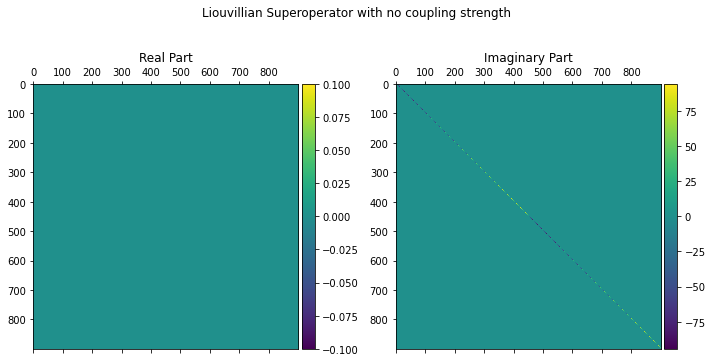

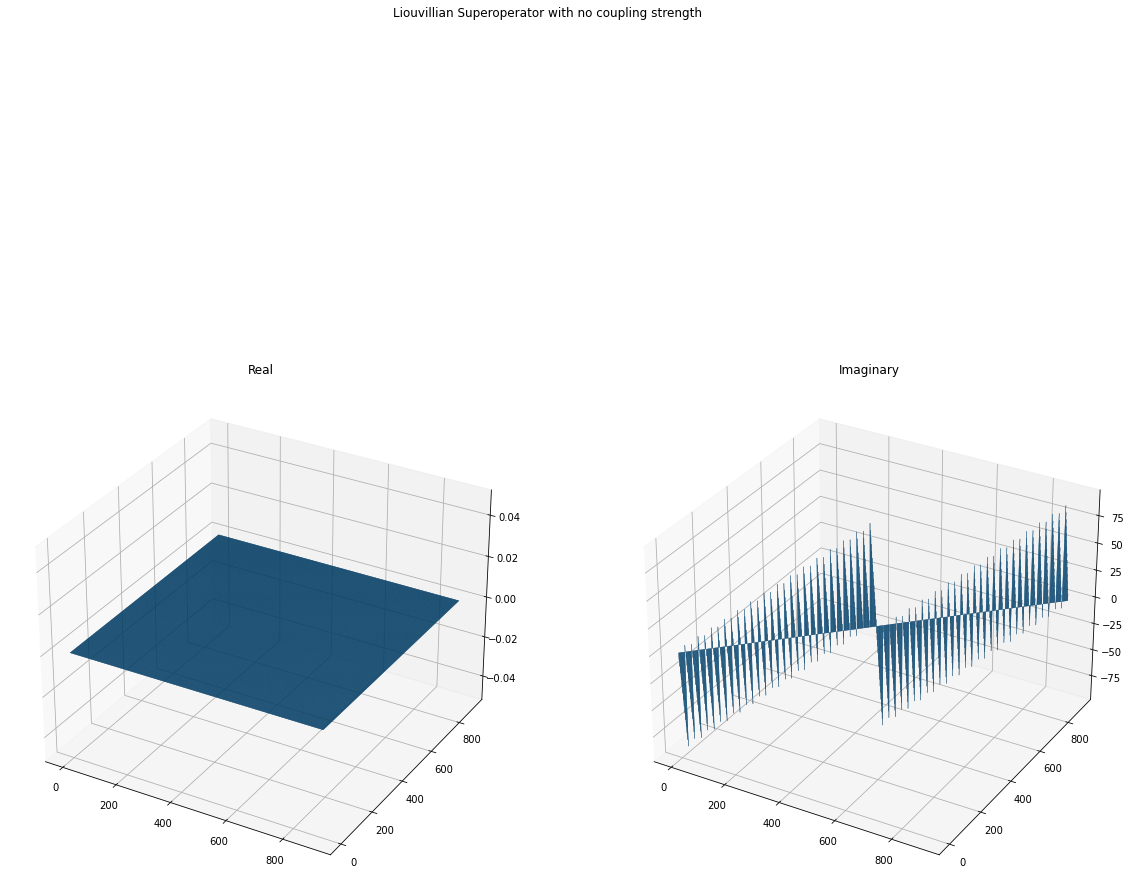

(<Figure size 1440x2880 with 2 Axes>,
 <Axes3DSubplot:title={'center':'Real'}>,
 <Axes3DSubplot:title={'center':'Imaginary'}>)

In [123]:
liouvillian_0 = liouvillian(H_0, [])            # Liouvillian of Free Hamiltonian

matrix_plot(liouvillian_0,
            title="Liouvillian Superoperator with no coupling strength")

matrix_plot3d(liouvillian_0,
             title="Liouvillian Superoperator with no coupling strength")


/var/folders/2m/dl_jl6yn26v6kjfqr3bdpwp00000gn/T/ipykernel_24358/3335173925.py:70: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax_real.set_zlim([np.amin(mat_real), np.amax(mat_real)])


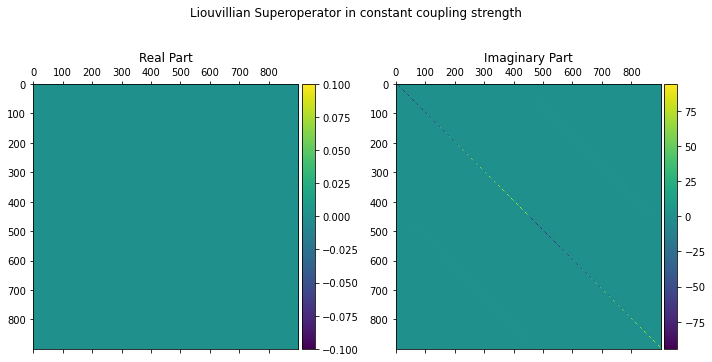

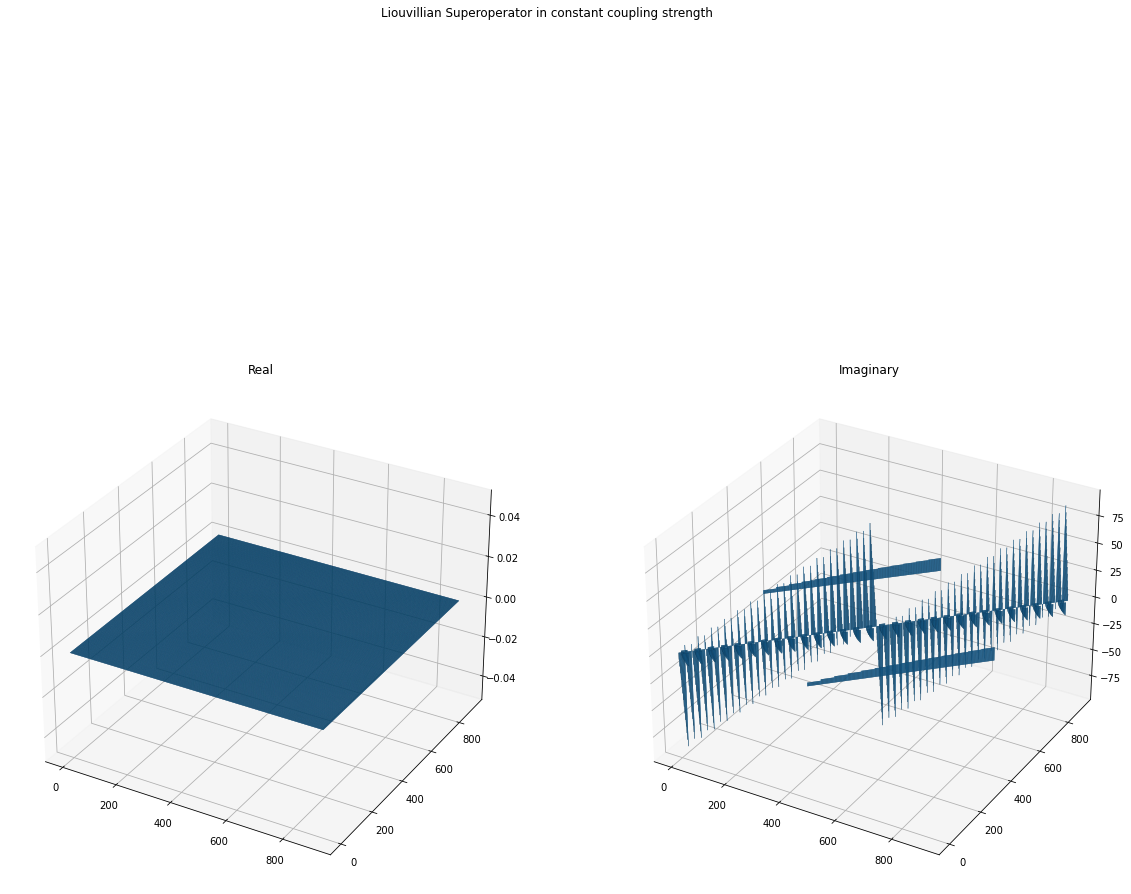

(<Figure size 1440x2880 with 2 Axes>,
 <Axes3DSubplot:title={'center':'Real'}>,
 <Axes3DSubplot:title={'center':'Imaginary'}>)

In [124]:
liouvillian_const_noise = liouvillian(H_const_noise, [])    # Liouvillian of the constant coupling strength

matrix_plot(liouvillian_const_noise, title="Liouvillian Superoperator in constant coupling strength")

matrix_plot3d(liouvillian_const_noise,
             title="Liouvillian Superoperator in constant coupling strength")


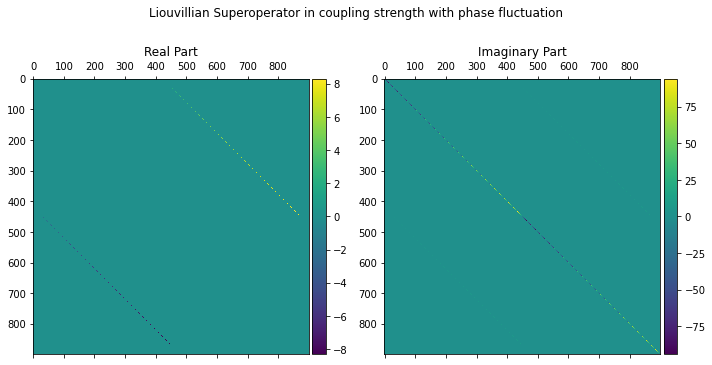

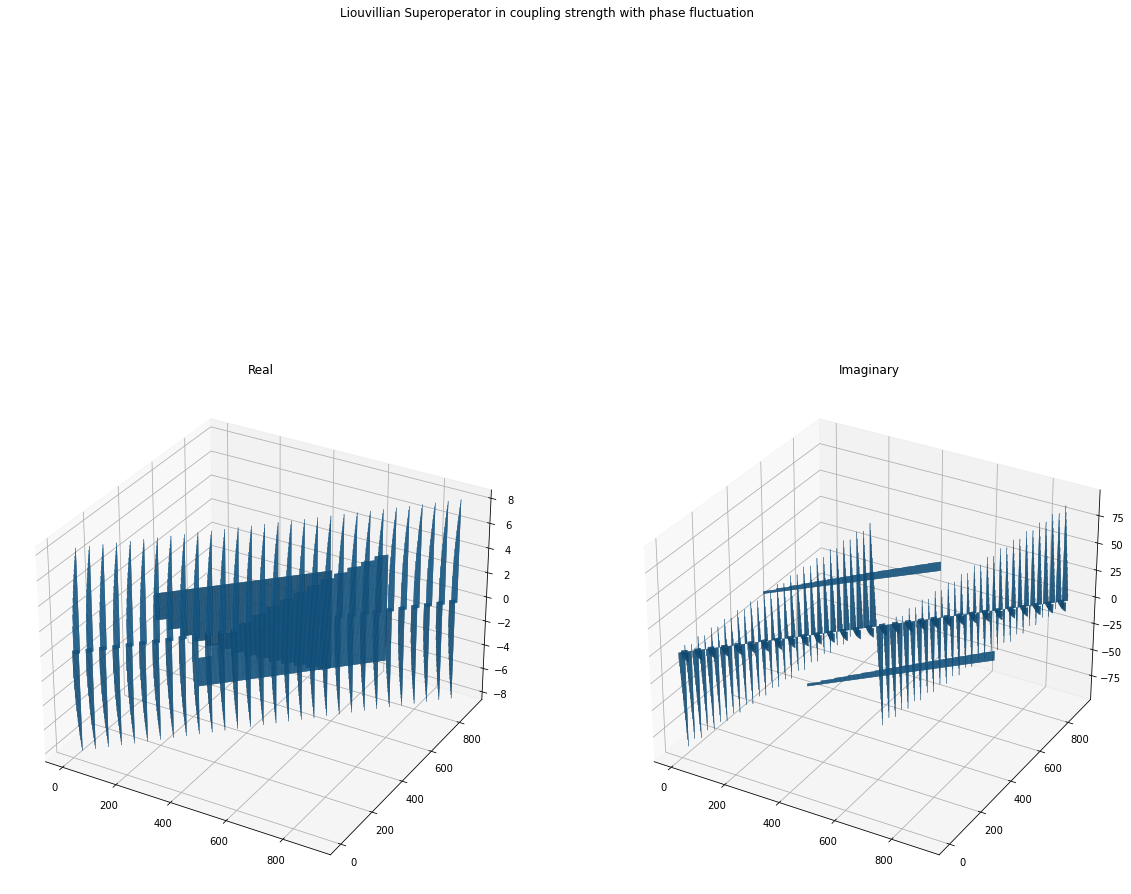

(<Figure size 1440x2880 with 2 Axes>,
 <Axes3DSubplot:title={'center':'Real'}>,
 <Axes3DSubplot:title={'center':'Imaginary'}>)

In [125]:
liouvillian_phase_fluc = liouvillian(H_1, [])  # Liouvillian of the coupling strength with phase fluctuation

matrix_plot(liouvillian_phase_fluc,
            title="Liouvillian Superoperator in coupling strength with phase fluctuation")

matrix_plot3d(liouvillian_phase_fluc,
             title="Liouvillian Superoperator in coupling strength with phase fluctuation")


Lectures on Quantum Tensor Networks, a pathway to modern diagrammatic reasoning : https://arxiv.org/pdf/1912.10049.pdf

### Transformation from Liouville to Choi

In QuTiP, Choi representation is defined by,

$$ J(\Phi) = (\mathbb{1}_{\mathrm{L}(\mathcal{X})} \otimes \Phi)(\mathrm{vec}(\mathbb{1}_\mathcal{X})\mathrm{vec}(\mathbb{1}_\mathcal{X}))$$

*Note*: This is column-stacking convention, which different from the Watrous' row-stacking convention.

From Liouville superopertor, we can apply the *bipartite column-reshuffling* to obtain Choi matrix.

**Definition** For some choices of complex Euclidean space $\mathcal{X},\mathcal{Y}$, the *bipartite matrices* take the form $M\in \mathrm{L}(\mathcal{X}\otimes \mathcal{Y})$ in which

$$ M_{m\mu, n\nu} := \langle m,\mu | M | n, \nu \rangle$$

where $|n\rangle \otimes |\nu\rangle \in \mathcal{X} \otimes \mathcal{Y}$.

The Choi matrix can be obtained by column-reshuffling the Liouville superoperator. To be more precise, the Liouville superoperator must undergo the transformation $ R : \mathrm{L}(\mathcal{X}\otimes\mathcal{Y}) \rightarrow \mathrm{L}(\mathcal{X}\otimes\mathcal{X}, \mathcal{Y}\otimes\mathcal{Y})$ which maps $M_{m\mu,n\nu} \mapsto M_{\mu\nu, mn}$.

### Transformation from Choi to Kraus

Using the fact that the channel is completely positive ($J(\Phi) > 0$), the spectral decomposition can be written as

$$ J(\Phi) = \sum_k \mu_k |\phi_k\rangle\langle\phi_k| $$

where $\mu_k \geq 0$ is an eigenvalue correponds to eigenvector $|\phi_k\rangle$. Here, we can make some algebraic manipulation $\mu_k |\phi_k\rangle\langle\phi_k| = \sqrt{\mu_k}|\phi_k\rangle (\sqrt{\mu_k} |\phi_k\rangle )^\dagger$. The term $\sqrt{\mu_k}|\phi_k\rangle$ is a vectorized version of the some operator $K_k$ such that $\mathrm{vec}(K_k) = \sqrt{\mu_k}|\phi_k\rangle$. The $K_k$ is Kraus operator.

In [126]:
kraus_list_0 = choi_to_kraus(super_to_choi(liouvillian_0))
kraus_list_const = choi_to_kraus(super_to_choi(liouvillian_const_noise))
kraus_list_1 = choi_to_kraus(super_to_choi(liouvillian_phase_fluc))

### Here, we derive the list of kraus operator by super ---> choi ---> kraus
### Plot all the Kraus operator (2 in each case)

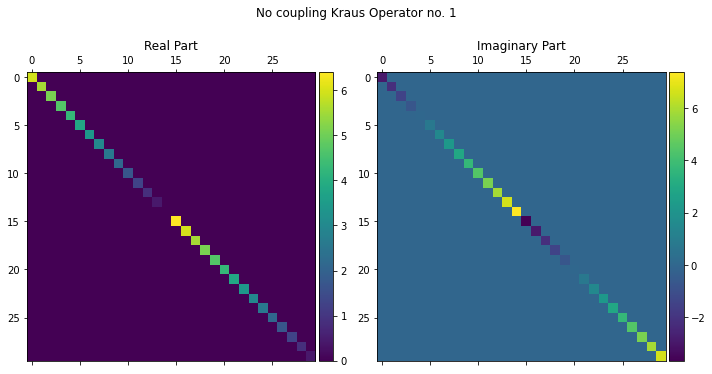

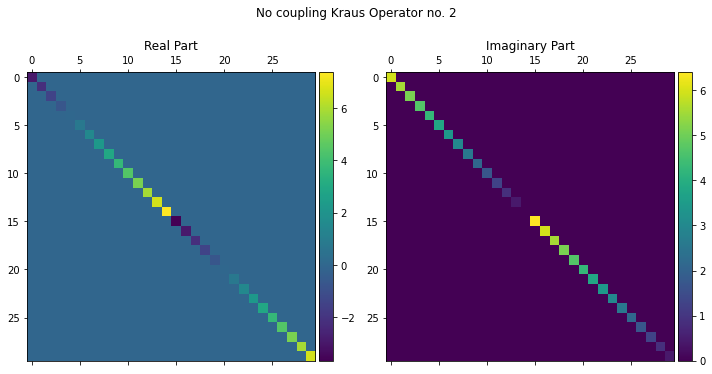

In [127]:
for idx, i in enumerate(kraus_list_0):
    matrix_plot(i, title="No coupling Kraus Operator no. " + str(idx + 1))
    # matrix_plot3d(i, title="No coupling Kraus Operator no. " + str(idx + 1))

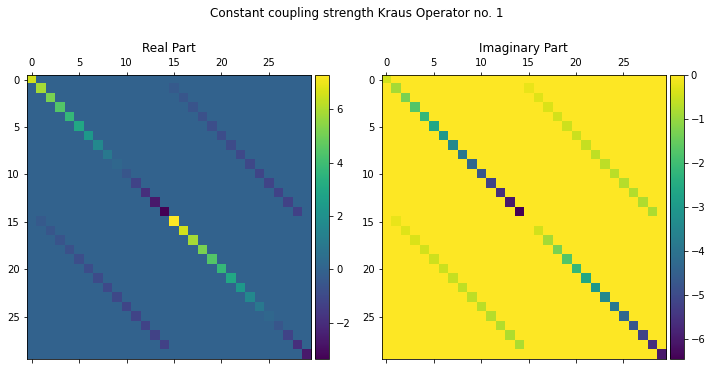

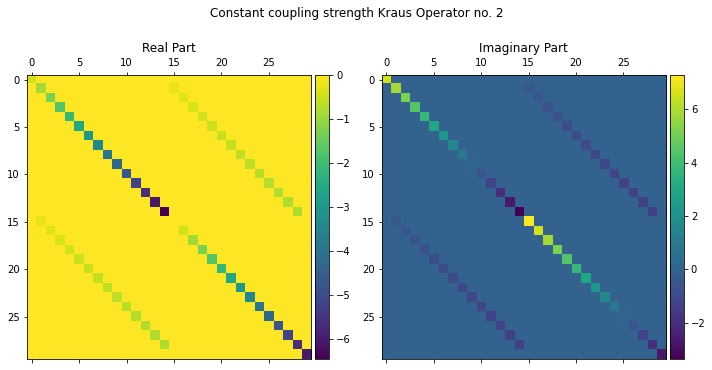

In [128]:
for idx, i in enumerate(kraus_list_const):
    matrix_plot(
        i, title="Constant coupling strength Kraus Operator no. " + str(idx + 1))
    # matrix_plot3d(
    #     i, title="Constant coupling strength Kraus Operator no. " + str(idx + 1))


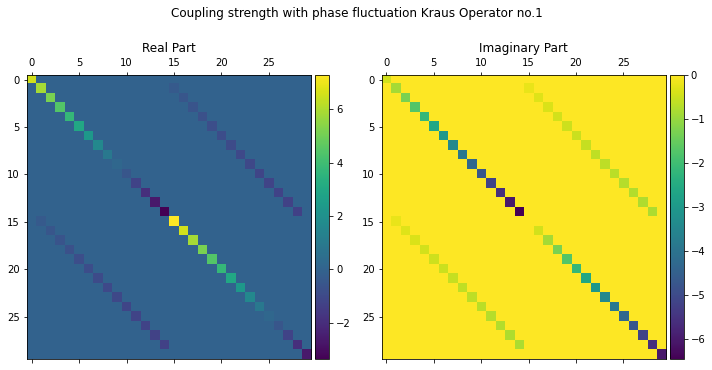

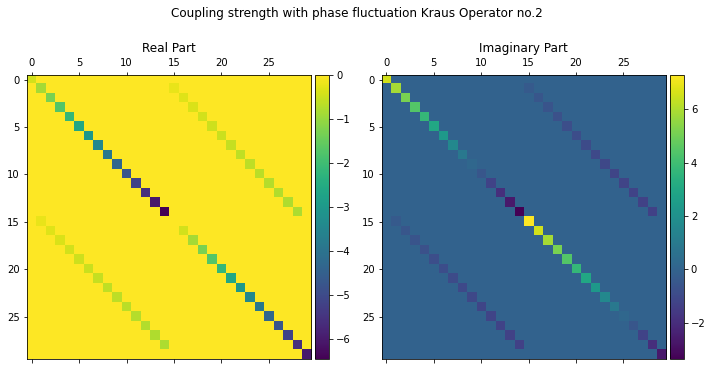

In [129]:
for idx, i in enumerate(kraus_list_const):
    matrix_plot(
        i, title="Coupling strength with phase fluctuation Kraus Operator no." + str(idx + 1))
    # matrix_plot3d(
    #     i, title="Coupling strength with phase fluctuation Kraus Operator no." + str(idx + 1))

### Liouvillian at any phase $\phi$ in coupling strength

Here, the animation of the Liouvillian superoperator matrix is created with the phase fluctuation $\phi$ as the parameter.

0
0
1
2
3
4
5
6
7
8
9


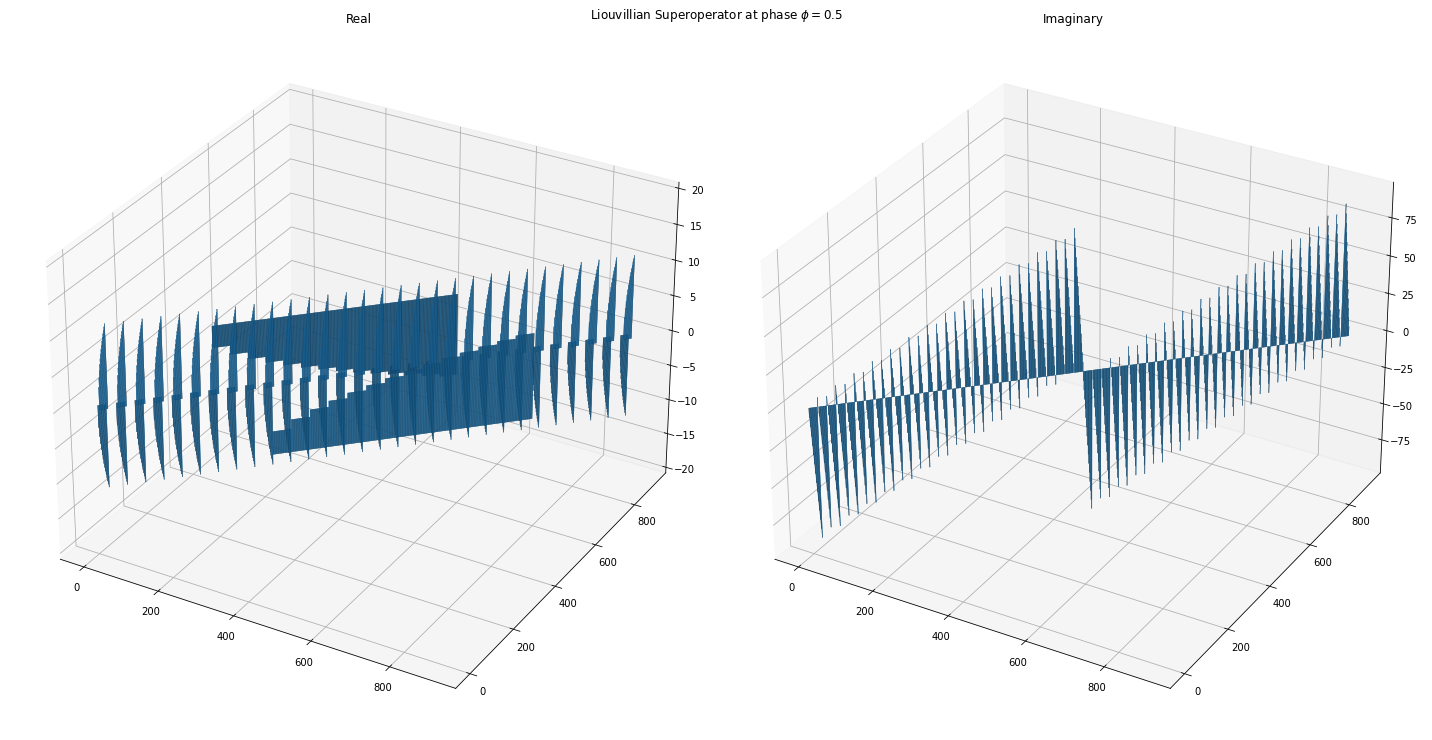

In [130]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation

phase_fluc_array = np.linspace(-0.5, 0.5, 10)

def create_liouvillian(pfluc):
        
    sample_g = g_res * np.exp(- pfluc * 1j * np.pi)
    H_sample = H_0 + sample_g * sm_q.dag() * a + sample_g.conj() * sm_q * a.dag()
    return liouvillian(H_sample, [])


fig = plt.figure(figsize=(20, 20))

ax_real = fig.add_subplot(121, projection='3d')
ax_imag = fig.add_subplot(122, projection='3d')

_x = np.arange(len(liouvillian_0.full()))
_y = np.arange(len((liouvillian_0.full())[0]))
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
ax_real.set_title('Real')
ax_imag.set_title('Imaginary')

bottom = np.zeros_like(x.ravel())
width = depth = 1

def create3dLiouville(mat):
    npmat = mat.full()
    mat_real = np.real(npmat)
    mat_imag = np.imag(npmat)

    ravel_imag_z = mat_imag.ravel()
    mask_imag = ravel_imag_z == 0
    ravel_real_z = mat_real.ravel()
    mask_real = ravel_real_z == 0

    ax_real.bar3d(x[~mask_real], y[~mask_real], bottom[~mask_real],
                  width, depth, ravel_real_z[~mask_real], shade=True)
    

    ax_imag.bar3d(x[~mask_imag], y[~mask_imag], bottom[~mask_imag],
                width, depth, ravel_imag_z[~mask_imag], shade=True)
    ax_real.set_title('Real')
    ax_imag.set_title('Imaginary')

    ax_imag.set_zlim([np.amin(mat_imag), np.amax(mat_imag)])
    ax_real.set_zlim([-20,20])

def phase_fluc(i):
    fig.suptitle("Liouvillian Superoperator at phase $\phi=" + str(phase_fluc_array[i]) + "$", y=0.75)
    ax_real.clear()
    ax_imag.clear()
    l_phase = create_liouvillian(phase_fluc_array[i])

    create3dLiouville(l_phase)

    print(f"Frame {i}: phi_0 = {phase_fluc_array[i]}")
    plt.tight_layout()


anim = FuncAnimation(fig, phase_fluc, frames=len(phase_fluc_array),
                     interval=60, repeat=False)
anim.save("phase_fluc_liouvillian.gif", savefig_kwargs={'facecolor': 'white'})
